Our plan is to use the tournament seeds as a predictor of tournament performance. 
We will train a logistic regressor on the difference in seeding between the two teams playing, and have the result of the game as the desired output

This is inspired by [last years competition][1], where [Jared Cross made a model just based on the team seeds][2].


  [1]: https://www.kaggle.com/c/march-machine-learning-mania-2016
  [2]: https://www.kaggle.com/jaredcross/march-machine-learning-mania-2016/getting-started

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["dir", "/b", "/a-d","input"], shell=True).decode("utf8"))

# Any results you write to the current directory are saved as output.

BBTeamSeasonStats.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TeamSpellings.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



## Load the training data ##
We are just having a look at the format of the training data to make sure that it looks like we expect

In [4]:
data_dir = 'input/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')

In [5]:
df_seeds.head()

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [6]:
df_tour.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Let's drop the columns we are not planning on using

In [7]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

Get the seeds as integers

In [8]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

## Merge seed for each team ##
We want the seeds in the same DataFrame as the game results

In [9]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [10]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [11]:
print(df_concat)

      Season  Wteam  Lteam  win_seed  loss_seed  seed_diff
0       1985   1116   1234         9          8          1
1       1985   1120   1345        11          6          5
2       1985   1207   1250         1         16        -15
3       1985   1229   1425         9          8          1
4       1985   1242   1325         3         14        -11
5       1985   1246   1449        12          5          7
6       1985   1256   1338         5         12         -7
7       1985   1260   1233         4         13         -9
8       1985   1314   1292         2         15        -13
9       1985   1323   1333         7         10         -3
10      1985   1326   1235         4         13         -9
11      1985   1328   1299         1         16        -15
12      1985   1374   1330         5         12         -7
13      1985   1385   1380         1         16        -15
14      1985   1396   1439         8          9         -1
15      1985   1424   1361         4         13         

## Make a new DF with just the wins and losses ##

In [ ]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [ ]:
print(df_for_predictions)

In [ ]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

In [101]:
print(X_train)

NameError: name 'X_train' is not defined

## Train the estimator ##
We use logistic regression, so we have to set a `C` value. We can just try a bunch of different values and then choose the best one.

In [ ]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

## Examine the classifier predictions ##

In [ ]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

In [ ]:
%matplotlib inline
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

This looks like we would expect. We are predicting the probability of team1 winning. If that team has a lower seed than team2, there is a high probability of team1 winning.

## Get the test data ##

In [ ]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmission.csv')
n_test_games = len(df_sample_sub)
print(n_test_games)

In [ ]:
print(df_sample_sub)

In [ ]:
df_sample_sub.head()

In [ ]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

We loop over each row in the `sample_submission.csv` file. For each row, we extract the year and the teams playing. 
We then look up the seeds for each of those teams *in that season*. 
Finally we add the seed difference to an array.

In [ ]:
X_test = np.zeros(shape=(n_test_games, 1))
print(X_test)

In [ ]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.Id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [ ]:
print(X_test)

## Make the predictions ##

In [ ]:
preds = clf.predict_proba(X_test)[:,1]
print(preds)

In [ ]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

In [ ]:
print(df_sample_sub)

## Save game predictions to .csv

In [ ]:
df_sample_sub.to_csv('logreg_on_seed.csv', index=False)

In [12]:
##Playing with plots data prep
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [13]:
df_wins2 = df_concat

In [14]:
df_wins2.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [15]:
df_loss2 = df_concat

In [16]:
df_loss2.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [17]:
##Drop unneded columns.
df_wins2.drop(labels=['Lteam'], inplace=True, axis=1)
df_loss2.drop(labels=['Wteam'], inplace=True, axis=1)

In [18]:
##Rename columns consistently for merge.
df_wins2 = df_wins2.rename(columns={'Wteam':'Team'})
df_loss2 = df_loss2.rename(columns={'Lteam':'Team'})

In [19]:
##Invert seed_diff for losing teams.
df_loss2['seed_diff'] = -df_loss2['seed_diff']

In [20]:
##Add and impute result column for wins.
df_wins2['result'] = 1

In [21]:
##Add and impute result column for losses.
df_loss2['result'] = 0

In [22]:
##Drop NaN values.
##This didn't work.  Don't know why.
df_wins2.dropna(how='any', inplace = True)
df_wins2.dropna(how='any', inplace = True)

In [23]:
##Combine winning and losing data into single dataframe.  Similar to UNION.
concats = [df_wins2, df_loss2]

df_forplay = pd.concat(concats)

In [24]:
df_forplay.head()

,Season,win_seed,loss_seed,seed_diff,result
0,1985,9,8,1,1
1,1985,11,6,5,1
2,1985,1,16,-15,1
3,1985,9,8,1,1
4,1985,3,14,-11,1


In [25]:
##Remove Nan results
##NOT working
df_nonan = df_forplay.dropna() 

In [26]:
##Create training and test sets for the data.
df_train, df_test = train_test_split(df_nonan, test_size=0.33)

In [27]:
df_train.head()

,Season,win_seed,loss_seed,seed_diff,result
1547,2009,1,16,15,0
1253,2004,1,5,4,0
1321,2005,1,3,-2,1
1412,2007,2,15,13,0
190,1988,4,13,-9,1


In [28]:
df_test.head()

,Season,win_seed,loss_seed,seed_diff,result
1895,2014,3,6,3,0
1791,2013,14,3,-11,0
598,1994,7,10,3,0
531,1993,9,8,-1,0
1769,2012,2,6,-4,1


In [29]:
##View Count, min, max, mean, std and quartiles for data set.
df_train.describe()

,Season,win_seed,loss_seed,seed_diff,result
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000
mean,2000.679286,4.938842,8.587914,-0.088096,0.508191
std,9.285401,3.767638,4.614866,7.487807,0.500024
min,1985.000000,1.000000,1.000000,-15.000000,0.000000
25%,1993.000000,2.000000,5.000000,-6.000000,0.000000
50%,2001.000000,4.000000,9.000000,0.000000,1.000000
75%,2009.000000,7.000000,13.000000,5.000000,1.000000
max,2016.000000,16.000000,16.000000,15.000000,1.000000


In [30]:
# Crosstab table of seed_diff vs result
result_seed_diff = pd.crosstab(index=df_train["result"], 
                           columns=df_train["seed_diff"],
                              margins=True)

result_seed_diff.index= ["loss","win", 'nan']

result_seed_diff

seed_diff,-15,-13,-12,-11,-10,-9,-8,-7,-6,-5,...,6,7,8,9,10,11,12,13,15,All
loss,0,6,0,15,2,18,44,42,4,44,...,8,108,107,71,3,76,4,77,81,1351
win,73,88,5,87,2,80,112,104,7,105,...,6,43,42,17,2,13,0,7,0,1396
nan,73,94,5,102,4,98,156,146,11,149,...,14,151,149,88,5,89,4,84,81,2747


In [31]:
import seaborn as sb
%matplotlib inline

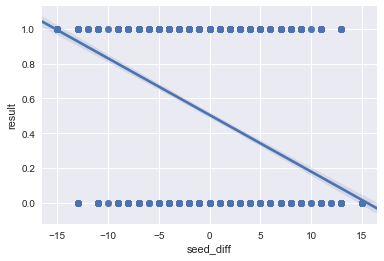

In [32]:
sb.regplot(x='seed_diff', y='result', data = df_train, scatter=True)

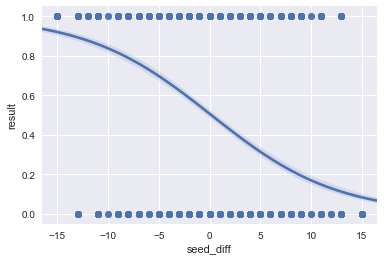

In [33]:
sb.regplot(x='seed_diff', y='result', data = df_train, scatter=True, logistic=True)

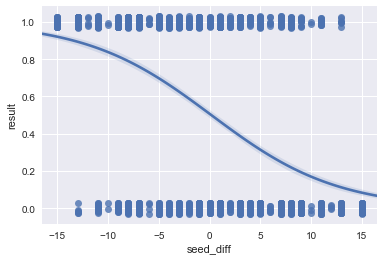

In [34]:
ax = sb.regplot(x='seed_diff', y='result', data=df_train,
                 logistic=True, n_boot=500, y_jitter=.1
               )

In [35]:
import scipy
from scipy.stats import spearmanr

In [36]:
diff = df_train['seed_diff']
result = df_train['result']
spearmanr_coefficient, p_value = spearmanr(diff,result, nan_policy='omit')


In [37]:
##Varies between -1 and +1 with 0 implying no correlation. 
##Positive correlations imply that as x increases, so does y. 
##Negative correlations imply that as x increases, y decreases.

print(spearmanr_coefficient)

-0.484096910802


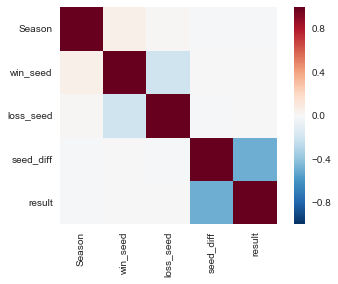

In [38]:
##Correlation heatmap
sb.heatmap(df_train.corr(), square=True)